In [2]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Scaling

In [4]:
# Define your scaling function
def custom_scaling(input_values):
    input_values_scaled = np.zeros_like(input_values, dtype=float)  # Initialize scaled data array
    input_values_scaled[:, 0] = (input_values[:, 0] - L_min) / (L_max - L_min)  # Scale L
    input_values_scaled[:, 1] = (input_values[:, 1] - C_min) / (C_max - C_min)  # Scale C
    input_values_scaled[:, 2] = (input_values[:, 2] - fsw_min) / (fsw_max - fsw_min)  # Scale fsw
    input_values_scaled[:, 3] = (input_values[:, 3] - t_dt_min) / (t_dt_max - t_dt_min) # Scale t_dt
    return input_values_scaled

# Search N and H

In [3]:


# Fix random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_13x13x13x13.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu", "P_D"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

X_scaled = custom_scaling(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")


# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)# Initialize a dictionary to store the training history for each configuration


histories = {}

# Initialize dictionaries to store the evaluation metrics for each configuration
mses = {}
maes = {}
rmses = {}
r2_scores = {}
mapes = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6, 7, 8]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256, 512]  # Number of neurons per hidden layer




Epoch 1/100, Loss: 3.6283962726593018, Val Loss: 2.586632251739502
Epoch 2/100, Loss: 2.504683017730713, Val Loss: 2.1690454483032227
Epoch 3/100, Loss: 2.2885758876800537, Val Loss: 1.99824857711792
Epoch 4/100, Loss: 2.117959976196289, Val Loss: 1.7498807907104492
Epoch 5/100, Loss: 1.9193272590637207, Val Loss: 1.4805372953414917
Epoch 6/100, Loss: 1.7356557846069336, Val Loss: 1.259627342224121
Epoch 7/100, Loss: 1.590512752532959, Val Loss: 1.1301368474960327
Epoch 8/100, Loss: 1.5086767673492432, Val Loss: 0.9961864352226257
Epoch 9/100, Loss: 1.4555466175079346, Val Loss: 0.9854100346565247
Epoch 10/100, Loss: 1.4393799304962158, Val Loss: 0.8833120465278625
Epoch 11/100, Loss: 1.4027131795883179, Val Loss: 0.864633321762085
Epoch 12/100, Loss: 1.3851360082626343, Val Loss: 0.8650912642478943
Epoch 13/100, Loss: 1.345496416091919, Val Loss: 0.8149692416191101
Epoch 14/100, Loss: 1.36348557472229, Val Loss: 0.80049729347229
Epoch 15/100, Loss: 1.3346302509307861, Val Loss: 0.8

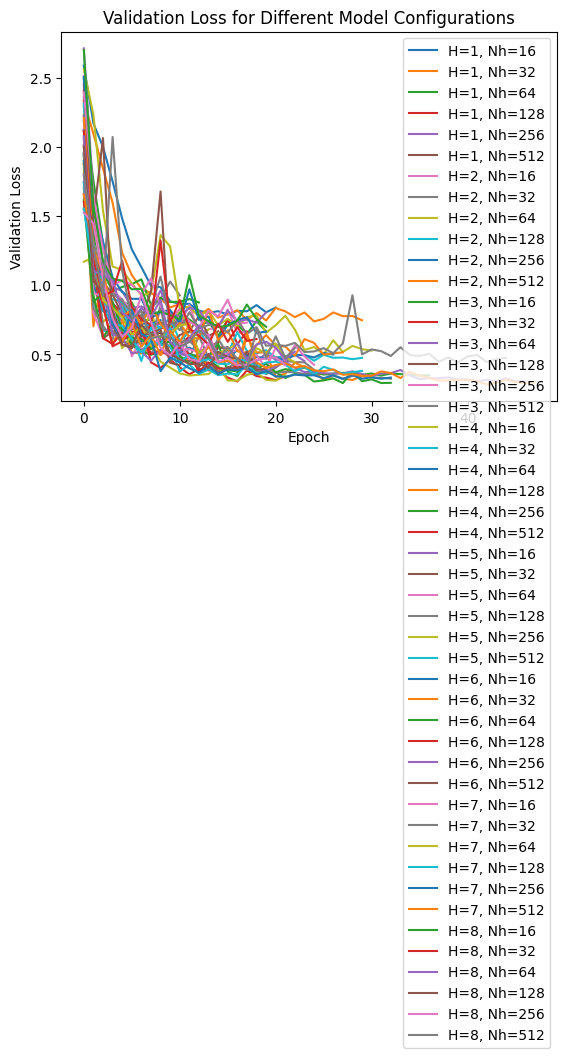

Model with H=1 and Nh=16:
MSE: 0.7690185308456421
MAE: 0.7690186268796488
RMSE: 5.818944042283149
R-squared: 0.8555529452770346
MAPE: 20.795245581033708%
Model with H=1 and Nh=32:
MSE: 0.751580536365509
MAE: 0.7515806059493976
RMSE: 4.51205227779794
R-squared: 0.892962110224058
MAPE: 17.52900608750558%
Model with H=1 and Nh=64:
MSE: 0.6351325511932373
MAE: 0.6351326207616422
RMSE: 4.3179267115004265
R-squared: 0.882551584451197
MAPE: 18.961862637218168%
Model with H=1 and Nh=128:
MSE: 0.6446740627288818
MAE: 0.6446742738733092
RMSE: 5.645336266765715
R-squared: 0.901843156690722
MAPE: 16.983373315413814%
Model with H=1 and Nh=256:
MSE: 0.6286788582801819
MAE: 0.6286788201713203
RMSE: 4.782328118311876
R-squared: 0.9109078619984043
MAPE: 16.05124831135469%
Model with H=1 and Nh=512:
MSE: 0.5931300520896912
MAE: 0.5931299615033997
RMSE: 4.376079046467293
R-squared: 0.892055423122632
MAPE: 14.84370291110825%
Model with H=2 and Nh=16:
MSE: 0.6794359087944031
MAE: 0.6794358376503575
RMSE: 4

In [4]:

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(4,)))  
        model.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model.add(tf.keras.layers.Dense(7, activation='softplus'))  

        # Compile the model
        model.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
    # Train the model with given hyperparameters
        history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories[(H, Nh)] = history

        # Evaluate the model on the testing set
        predictions = model.predict(X_test)

        # Evaluate the model on the testing set and calculate MSE
        mse = model.evaluate(X_test, y_test)
        mses[(H, Nh)] = mse

        # Calculate Mean Absolute Error (MAE)
        mae = mean_absolute_error(y_test, predictions)
        maes[(H, Nh)] = mae

        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mean_squared_error(y_test, predictions))
        rmses[(H, Nh)] = rmse

        # Calculate R-squared (R2) Score
        r2 = r2_score(y_test, predictions)
        r2_scores[(H, Nh)] = r2

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
        mapes[(H, Nh)] = mape

# Plot the validation loss for each configuration
for (H, Nh), history in histories.items():
    plt.plot(history.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the MSE for each configuration
# Print the evaluation metrics for each configuration
for (H, Nh), mse in mses.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse}')
    print(f'MAE: {maes[(H, Nh)]}')
    print(f'RMSE: {rmses[(H, Nh)]}')
    print(f'R-squared: {r2_scores[(H, Nh)]}')
    print(f'MAPE: {mapes[(H, Nh)]}%')


## Ranking

In [5]:
# Rank combinations based on their MSE values
ranked_combinations = sorted(mses.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse) in enumerate(ranked_combinations, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse}")


Rank 1: Combination H=7, Nh=512 - MSE: 0.28495562076568604
Rank 2: Combination H=4, Nh=256 - MSE: 0.2946063280105591
Rank 3: Combination H=6, Nh=256 - MSE: 0.2977372109889984
Rank 4: Combination H=4, Nh=512 - MSE: 0.2984634041786194
Rank 5: Combination H=5, Nh=256 - MSE: 0.31067249178886414
Rank 6: Combination H=4, Nh=128 - MSE: 0.3110850751399994
Rank 7: Combination H=7, Nh=256 - MSE: 0.3276594281196594
Rank 8: Combination H=5, Nh=128 - MSE: 0.32962122559547424
Rank 9: Combination H=6, Nh=64 - MSE: 0.341655969619751
Rank 10: Combination H=5, Nh=512 - MSE: 0.34304121136665344
Rank 11: Combination H=7, Nh=128 - MSE: 0.3475469946861267
Rank 12: Combination H=3, Nh=512 - MSE: 0.3498395085334778
Rank 13: Combination H=6, Nh=512 - MSE: 0.35607102513313293
Rank 14: Combination H=6, Nh=128 - MSE: 0.36403411626815796
Rank 15: Combination H=3, Nh=128 - MSE: 0.3828272819519043
Rank 16: Combination H=8, Nh=128 - MSE: 0.3832457363605499
Rank 17: Combination H=8, Nh=512 - MSE: 0.393792986869812
Ran

## Try spesific N and H

In [6]:
# Specify the combination you want to call
H = 7
Nh = 512

# Retrieve the model for the specified combination
selected_model = histories[(H, Nh)].model
selected_model.save("model_7_512_13_13.h5")
# Use the trained model to make predictions on the testing set
predictions = selected_model.predict(X_test)

# Evaluate the model on the testing set
mse = selected_model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

NameError: name 'histories' is not defined

# Machine Learning




Epoch 1/100, Loss: 198.24034118652344, Val Loss: 55.84252166748047
Epoch 2/100, Loss: 162.07220458984375, Val Loss: 1063.22265625
Epoch 3/100, Loss: 159.11221313476562, Val Loss: 68.34588623046875
Epoch 4/100, Loss: 140.32313537597656, Val Loss: 463.4163513183594
Epoch 5/100, Loss: 102.2571792602539, Val Loss: 26.709251403808594
Epoch 6/100, Loss: 72.52664947509766, Val Loss: 13.126338958740234
Epoch 7/100, Loss: 63.106285095214844, Val Loss: 19.624740600585938
Epoch 8/100, Loss: 65.6215591430664, Val Loss: 16.596755981445312
Epoch 9/100, Loss: 69.17135620117188, Val Loss: 18.033472061157227
Epoch 10/100, Loss: 61.30695343017578, Val Loss: 32.22014617919922
Epoch 11/100, Loss: 64.91913604736328, Val Loss: 22.960651397705078
Restoring model weights from the end of the best epoch: 6.
Epoch 11: early stopping


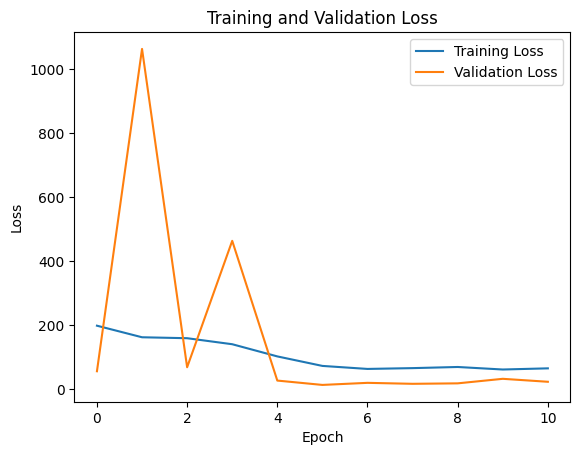

In [5]:
# Load your simulation data
# Replace "your_dataset.csv" with the path to your dataset
df = pd.read_csv(r"D:\Krishna\ai-power-converter\dataset\simulation_results_13x13x13x13.csv")

# Extract input features (L, C, fsw)
X = df[['L', 'C', 'fsw', "t_dt"]].values

# Extract output (ripples)
y = df[["delta_current", "delta_voltage", "Pl_s1", "Pl_s2", "Pl_C", "Pl_L_Cu", "P_D"]].values  # Adjust column names as per your dataset

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 0.178e-6, 1e-6

# Apply custom scaling
X_scaled = custom_scaling(X)

# Split the dataset into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")

# Assuming you have already defined your machine learning model and dataset
# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)

model = tf.keras.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(4,)),  # Scalarization layer
    tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 1
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),         
    tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 1
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),                  # Batch normalization
    tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),    
    tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation='softplus')                               # Output layer with 6 neurons
])

# model = tf.keras.Sequential([
#     tf.keras.layers.BatchNormalization(input_shape=(3,)),  # Scalarization layer
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 1
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),         
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),                  # Batch normalization
#     tf.keras.layers.Dense(512, activation='relu'),          # Hidden layer 2
#     tf.keras.layers.BatchNormalization(),         
#     tf.keras.layers.Dense(6, activation='softplus')                               # Output layer with 6 neurons
# ])


# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model with given hyperparameters
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), 
                        callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing Set

In [10]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Use the trained model to make predictions on the testing set
predictions = model.predict(X_test)

# Print the first few predictions
print("Predictions:")
print(predictions[:5])

# Print the corresponding true values
print("True Values:")
print(y_test[:5])

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse}')

# Calculate R-squared (R2) Score
r2 = r2_score(y_test, predictions)
print(f'R-squared (R2) Score: {r2}')

# Calculate Mean Absolute Percentage Error (MAPE)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
print(f'Mean Absolute Percentage Error (MAPE): {mape}%')

127/127 [==============================] - 0s 1ms/step - loss: 0.1033
Mean Squared Error on Testing Set: 0.10327570140361786
127/127 [==============================] - 0s 989us/step
Predictions:
[[0.04683643 0.98075175 3.1670532  3.183984   0.01767796 1.9803311 ]
 [0.63571066 5.6320786  1.7932947  1.742603   0.03286593 0.7753885 ]
 [0.09879279 7.26692    3.519491   3.4581873  0.01066541 1.351817  ]
 [0.09455513 1.0213867  3.5961487  3.6080532  0.01899    0.960834  ]
 [0.04262336 1.1857657  3.476276   3.4671586  0.0124905  2.1476464 ]]
True Values:
[[3.73126122e-02 7.47245981e-01 3.03643319e+00 3.03643319e+00
  1.72160434e-02 2.15202491e+00]
 [9.49393284e-01 4.47959053e+00 1.85248205e+00 1.85248205e+00
  7.27748221e-02 1.05888718e+00]
 [1.82801723e-01 9.05225544e+00 3.44051329e+00 3.44051329e+00
  6.14689682e-03 1.17069267e+00]
 [7.21944866e-02 1.01012118e+00 3.53549404e+00 3.53549404e+00
  2.30594268e-02 9.72148356e-01]
 [2.94638994e-02 1.12389005e+00 3.32770238e+00 3.32770238e+00
  1.

## Save Model

In [ ]:
# Evaluate the model on the testing set
mse = model.evaluate(X_test, y_test)
print("Mean Squared Error on Testing Set:", mse)

# Optionally, save the model
model.save("ripples_prediction_model.h5")
